In [1]:
import torch

# 支持函数
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

def cross_entrophy(yhat, y, label_smooth=0.1):
    # yhat是二维向量，第一个维度是batch， y是单维度的labels
    # 有待进一步测试
    real_y = torch.zeros(yhat.shape)
    real_y += label_smooth/yhat.shape[1]   # 应该能广播吧
    real_y[range(len(yhat)), y] += 1 - label_smooth
    loss = -torch.mul(real_y, torch.log(yhat))
    #除以batchsize
    return loss.sum(1, keepdim=True) / len(y)




In [2]:
# 更新参数
def sgd(params, lr):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()



In [3]:
# 评估模型的支持函数
def accuracy(yhat, y):
    # 计算正确的***数量***
    if len(yhat.shape) > 1 and yhat.shape[1] > 1:
        yhat = yhat.argmax(axis=1)
    cmp = yhat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter, lossfun):
    # 三个参数都是function
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = [0.0, 0.0]
    total_loss = 0
    for X, y in data_iter:
        yhat = net(X)
        metric[0] += accuracy(yhat, y)
        total_loss += lossfun(yhat=yhat, y=y).sum()
        metric[1] += y.shape[0]
    # 正确率和平均损失
    return metric[0]/metric[1], total_loss/metric[1]


In [4]:
# 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = [0.0, 0.0, 0.0]
    for X, y in train_iter:
        #print(X.shape)
        #print(y.shape)
        yhat = net(X)
        l = loss(yhat=yhat, y=y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backword()
            updater.step()
            metric[0] += accuracy(yhat, y)
            metric[1] += y.shape[0]
            metric[2] += float(l) * len(y)
        else:
            l.sum().backward()
            updater()
            metric[0] += accuracy(yhat, y)
            metric[1] += y.shape[0]
            metric[2] += float(l.sum())
    # 正确率和平均损失
    return metric[0]/metric[1], metric[2]/metric[1]


In [5]:
# 训练主模块

# hyperparameter
lr = 0.01
num_epoch = 20
batch_size = 100

inputlayer = 784
hiddenlayer = 128
outputlayer = 10

# 初始化参数
Omega1 = torch.normal(0, 0.01, (inputlayer, hiddenlayer), requires_grad=True)
Theta1 = torch.zeros((1, hiddenlayer), requires_grad=True)
Omega2 = torch.normal(0, 0.01, (hiddenlayer, outputlayer), requires_grad=True)
Theta2 = torch.zeros((1, outputlayer), requires_grad=True)

def myUpdater():
    return sgd([Omega1, Theta1, Omega2, Theta2], lr)

# 定义模型
def FC2Layer_model(x):
    x = torch.matmul(x, Omega1) - Theta1
    x = torch.nn.functional.relu(x)
    x = torch.matmul(x, Omega2) - Theta2
    x = torch.nn.functional.sigmoid(x)
    return softmax(x) #用自己的softmax看看


# 数据导入
from datareader import MNISTReader
train_reader = MNISTReader(1)
test_reader = MNISTReader(2)



In [6]:

data_l = []
for epoch in range(num_epoch):
    if epoch == 9:
        lr /= 2
    train_accu, train_loss = train_epoch_ch3(net=FC2Layer_model, train_iter=train_reader.dataIter(batch_size), loss=cross_entrophy, updater=myUpdater)

    # 计算测试集
    test_accu, teat_loss = evaluate_accuracy(net=FC2Layer_model, data_iter=test_reader.dataIter(batch_size), lossfun=cross_entrophy)
    data_l.append((train_accu, train_loss, test_accu, teat_loss))
    print(f'epoch: {epoch+1}; accuracy: train = {train_accu}, test = {test_accu}; loss: train = {train_loss}, test = {teat_loss}')


epoch: 1; accuracy: train = 0.18046666666666666, test = 0.234
loss: train = 0.022897454539934792, test = 0.022643841803073883
epoch: 2; accuracy: train = 0.46448333333333336, test = 0.6512
loss: train = 0.021969129582246144, test = 0.020968718454241753
epoch: 3; accuracy: train = 0.7120333333333333, test = 0.7621
loss: train = 0.020058647257089616, test = 0.0192653127014637
epoch: 4; accuracy: train = 0.7639333333333334, test = 0.7741
loss: train = 0.018894253454605738, test = 0.018511274829506874
epoch: 5; accuracy: train = 0.7770166666666667, test = 0.7877
loss: train = 0.018337436511119208, test = 0.018090320751070976
epoch: 6; accuracy: train = 0.79115, test = 0.8068
loss: train = 0.017990594871838888, test = 0.017798947170376778
epoch: 7; accuracy: train = 0.8045333333333333, test = 0.8173
loss: train = 0.017742850746711097, test = 0.017585765570402145
epoch: 8; accuracy: train = 0.81495, test = 0.8305
loss: train = 0.017560585621992746, test = 0.017430508509278297
epoch: 9; accur

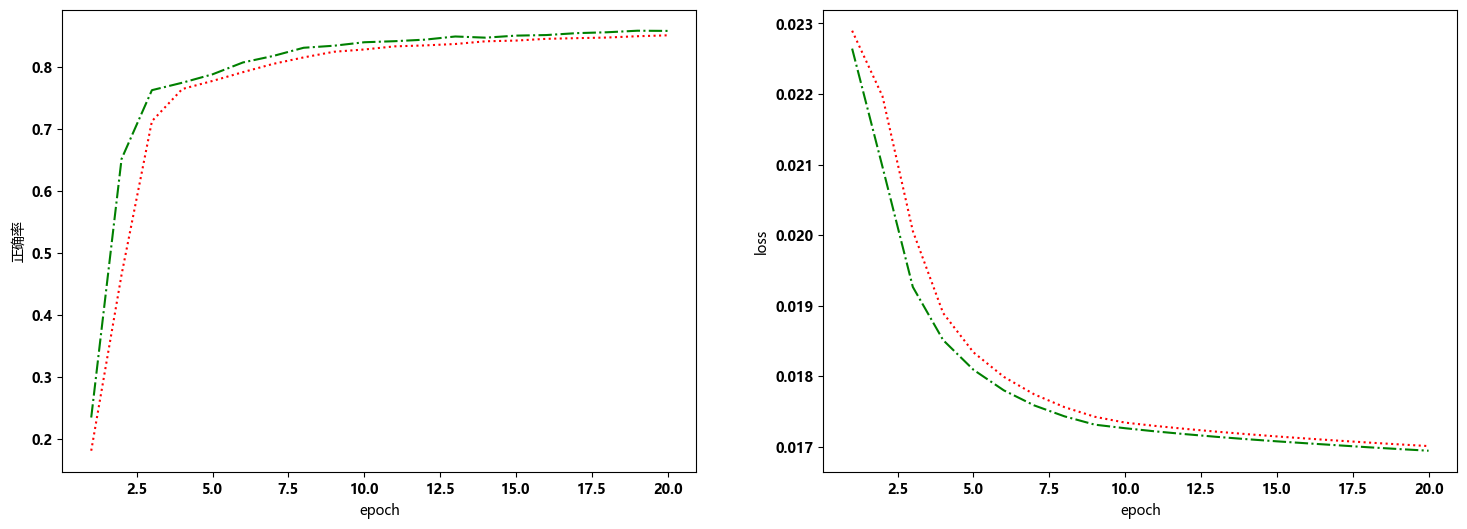

In [16]:

#绘图
import matplotlib.pyplot as plt

epoch_l = [i for i in range(1, num_epoch+1)]
y1 = [x[0] for x in data_l]
y2 = [x[2] for x in data_l]

y3 = [x[1] for x in data_l]
y4 = [float(x[3]) for x in data_l]

plt.figure(figsize=(18, 6), dpi=100)
plt.rc("font", family='MicroSoft YaHei', weight="bold")

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('正确率')
plt.plot(epoch_l, y1, color='red', linestyle=':', label='train set')
plt.plot(epoch_l, y2, color='green', linestyle='-.', label='test set')

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch_l, y3, color='red', linestyle=':', label='train set')
plt.plot(epoch_l, y4, color='green', linestyle='-.', label='test set')

plt.show()




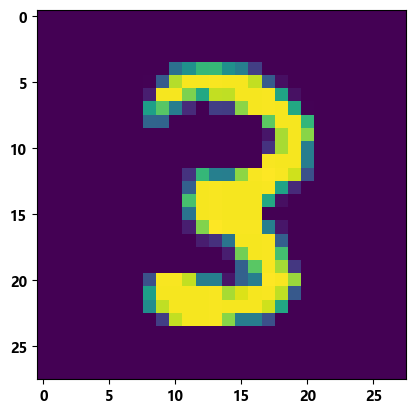

tensor([[0.0725, 0.0726, 0.1232, 0.1888, 0.0725, 0.0726, 0.0725, 0.0725, 0.1800,
         0.0726]], grad_fn=<DivBackward0>)
模型预测数字为: 3，正确答案为: 3，

输入任意值继续:  


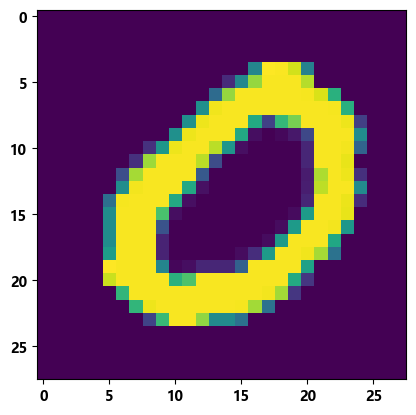

tensor([[0.2041, 0.0751, 0.0751, 0.0751, 0.0751, 0.1924, 0.0778, 0.0751, 0.0752,
         0.0751]], grad_fn=<DivBackward0>)
模型预测数字为: 0，正确答案为: 0，

输入任意值继续:  


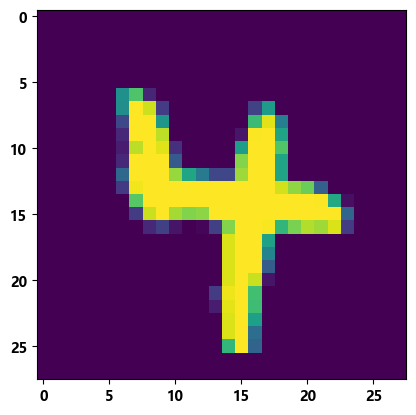

tensor([[0.0739, 0.0739, 0.0739, 0.0741, 0.2006, 0.0750, 0.0758, 0.0781, 0.0740,
         0.2007]], grad_fn=<DivBackward0>)
模型预测数字为: 9，正确答案为: 4，

输入任意值继续:  


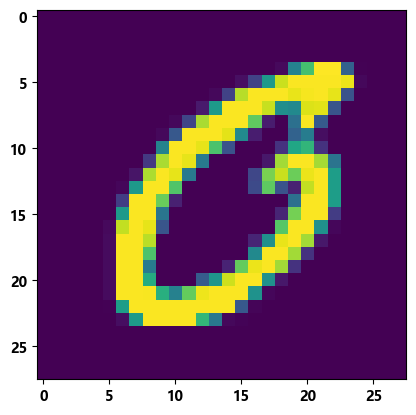

tensor([[0.2243, 0.0827, 0.0828, 0.0828, 0.0827, 0.1122, 0.0831, 0.0835, 0.0827,
         0.0830]], grad_fn=<DivBackward0>)
模型预测数字为: 0，正确答案为: 0，

输入任意值继续:  


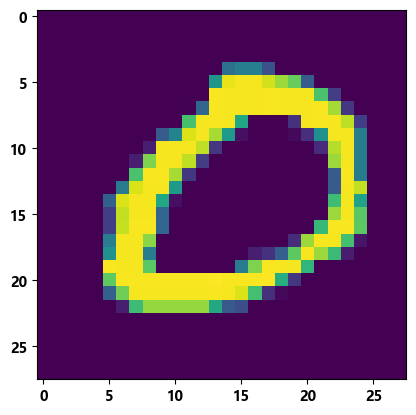

tensor([[0.2077, 0.0764, 0.0766, 0.0765, 0.0764, 0.1756, 0.0814, 0.0764, 0.0765,
         0.0764]], grad_fn=<DivBackward0>)
模型预测数字为: 0，正确答案为: 0，

输入任意值继续:  


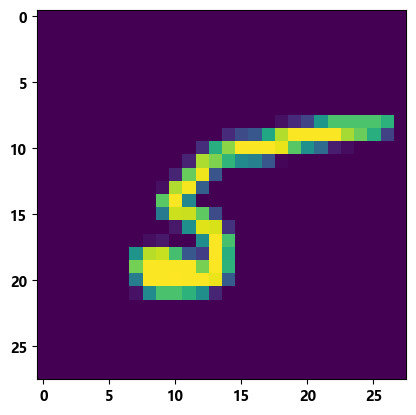

tensor([[0.0876, 0.0934, 0.0847, 0.0826, 0.0839, 0.1900, 0.1263, 0.0826, 0.0863,
         0.0826]], grad_fn=<DivBackward0>)
模型预测数字为: 5，正确答案为: 5，

输入任意值继续:  


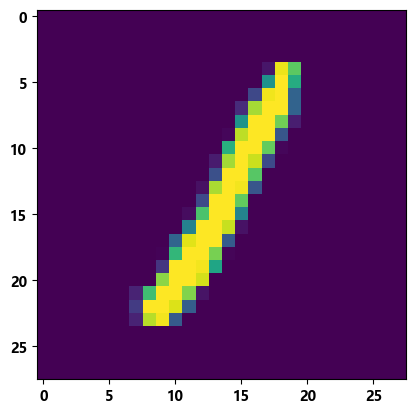

tensor([[0.0828, 0.2243, 0.1034, 0.0845, 0.0829, 0.0836, 0.0831, 0.0834, 0.0892,
         0.0828]], grad_fn=<DivBackward0>)
模型预测数字为: 1，正确答案为: 1，

输入任意值继续:  


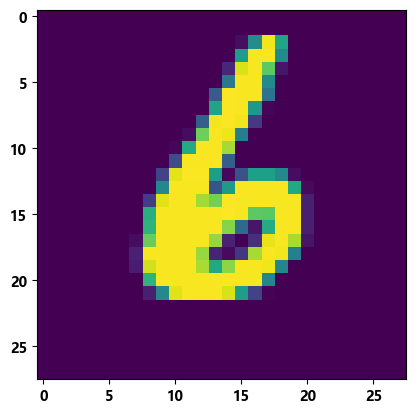

tensor([[0.0839, 0.0839, 0.0886, 0.0839, 0.0881, 0.0847, 0.2281, 0.0839, 0.0907,
         0.0840]], grad_fn=<DivBackward0>)
模型预测数字为: 6，正确答案为: 6，

输入任意值继续:  


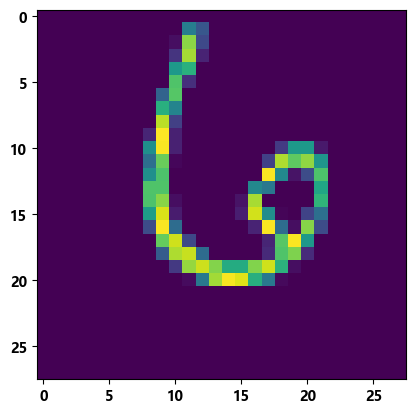

tensor([[0.0842, 0.0833, 0.0859, 0.0833, 0.1191, 0.0838, 0.1996, 0.0847, 0.0833,
         0.0927]], grad_fn=<DivBackward0>)
模型预测数字为: 6，正确答案为: 6，

输入任意值继续:  


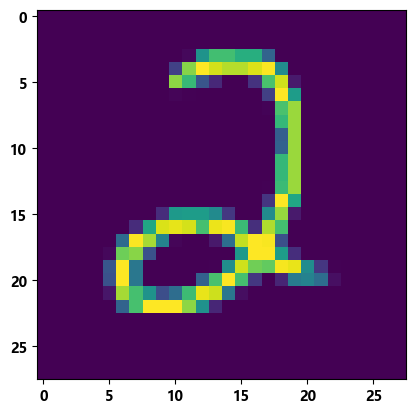

tensor([[0.0863, 0.0846, 0.2259, 0.0879, 0.0847, 0.0845, 0.0924, 0.0846, 0.0845,
         0.0845]], grad_fn=<DivBackward0>)
模型预测数字为: 2，正确答案为: 2，

输入任意值继续:  


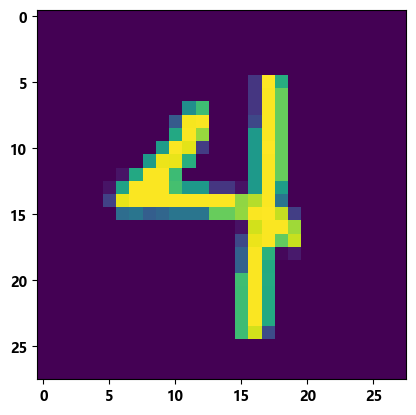

tensor([[0.0736, 0.0736, 0.0736, 0.0737, 0.1971, 0.0862, 0.0741, 0.0751, 0.0738,
         0.1992]], grad_fn=<DivBackward0>)
模型预测数字为: 9，正确答案为: 4，

输入任意值继续:  


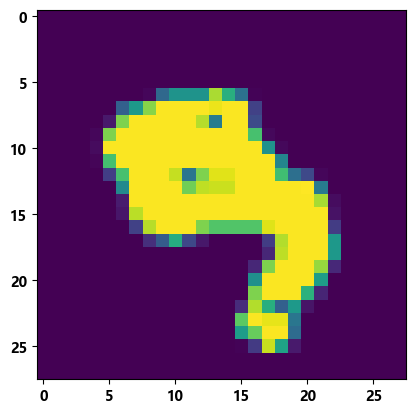

tensor([[0.0730, 0.0730, 0.0730, 0.0736, 0.1820, 0.1015, 0.0746, 0.0731, 0.0788,
         0.1974]], grad_fn=<DivBackward0>)
模型预测数字为: 9，正确答案为: 9，

输入任意值继续:  


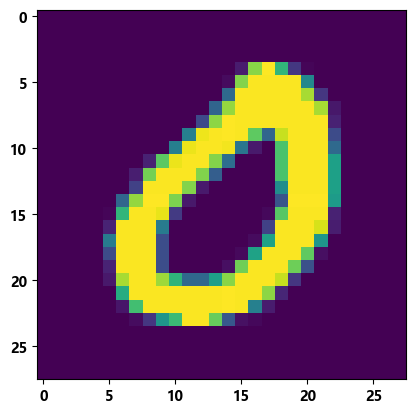

tensor([[0.2303, 0.0847, 0.0848, 0.0849, 0.0847, 0.0914, 0.0848, 0.0848, 0.0847,
         0.0847]], grad_fn=<DivBackward0>)
模型预测数字为: 0，正确答案为: 0，

输入任意值继续:  


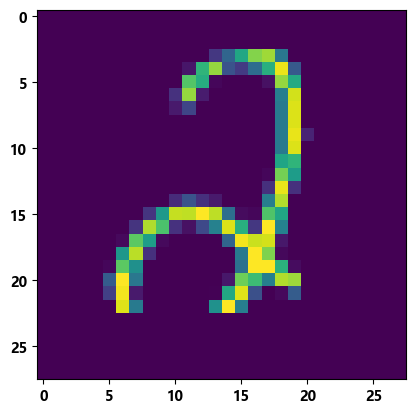

tensor([[0.0889, 0.0888, 0.1858, 0.0930, 0.0940, 0.0889, 0.0940, 0.0889, 0.0886,
         0.0891]], grad_fn=<DivBackward0>)
模型预测数字为: 2，正确答案为: 2，

KeyboardInterrupt: Interrupted by user

In [19]:
# 展示效果
import matplotlib.pyplot as plt
from os import system
for imdata, label in test_reader.dataIter(1):
    system('cls')
    predict_re = FC2Layer_model(imdata)
    imdata = imdata *128 + 128
    imdata = imdata.reshape((28, 28))
    fig = plt.figure()
    plt.imshow(imdata)
    plt.show()
    print(predict_re)
    predict_num = torch.argmax(predict_re)
    print(f'模型预测数字为: {predict_num}，正确答案为: {int(label)}，', end='')
    input('输入任意值继续: ')